In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
plt.style.use('default')

In [4]:
!wget https://github.com/kairess/eye_blink_detector/archive/refs/heads/master.zip

--2022-07-31 18:05:21--  https://github.com/kairess/eye_blink_detector/archive/refs/heads/master.zip
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/kairess/eye_blink_detector/zip/refs/heads/master [following]
--2022-07-31 18:05:21--  https://codeload.github.com/kairess/eye_blink_detector/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 192.30.255.121
Connecting to codeload.github.com (codeload.github.com)|192.30.255.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [      <=>           ]  28.69M  11.0MB/s    in 2.6s    

2022-07-31 18:05:25 (11.0 MB/s) - ‘master.zip’ saved [30088013]



In [5]:
!unzip master.zip
!rm -rf master.zip

Archive:  master.zip
118b15c7a1444411cc823a540b23ad2db94c7167
   creating: eye_blink_detector-master/
 extracting: eye_blink_detector-master/.gitignore  
  inflating: eye_blink_detector-master/README.md  
   creating: eye_blink_detector-master/dataset/
  inflating: eye_blink_detector-master/dataset/dataset.csv  
  inflating: eye_blink_detector-master/dataset/x_train.npy  
  inflating: eye_blink_detector-master/dataset/x_val.npy  
  inflating: eye_blink_detector-master/dataset/y_train.npy  
  inflating: eye_blink_detector-master/dataset/y_val.npy  
  inflating: eye_blink_detector-master/helpers.py  
   creating: eye_blink_detector-master/models/
  inflating: eye_blink_detector-master/models/2018_12_17_22_58_35.h5  
  inflating: eye_blink_detector-master/preprocess.ipynb  
  inflating: eye_blink_detector-master/test.py  
  inflating: eye_blink_detector-master/train.ipynb  
   creating: eye_blink_detector-master/videos/
  inflating: eye_blink_detector-master/videos/1.mp4  
  inflating: ey

In [6]:
x_train = np.load('/content/eye_blink_detector-master/dataset/x_train.npy').astype(np.float32)
y_train = np.load('/content/eye_blink_detector-master/dataset/y_train.npy').astype(np.float32)
x_val = np.load('/content/eye_blink_detector-master/dataset/x_val.npy').astype(np.float32)
y_val = np.load('/content/eye_blink_detector-master/dataset/y_val.npy').astype(np.float32)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(2586, 26, 34, 1) (2586, 1)
(288, 26, 34, 1) (288, 1)


In [7]:
x_train

array([[[[ 51.],
         [ 53.],
         [ 51.],
         ...,
         [ 63.],
         [ 62.],
         [ 60.]],

        [[ 48.],
         [ 43.],
         [ 36.],
         ...,
         [ 73.],
         [ 67.],
         [ 74.]],

        [[ 30.],
         [ 28.],
         [ 28.],
         ...,
         [121.],
         [112.],
         [107.]],

        ...,

        [[113.],
         [117.],
         [118.],
         ...,
         [163.],
         [164.],
         [164.]],

        [[121.],
         [125.],
         [119.],
         ...,
         [166.],
         [166.],
         [160.]],

        [[128.],
         [132.],
         [126.],
         ...,
         [167.],
         [164.],
         [158.]]],


       [[[193.],
         [196.],
         [200.],
         ...,
         [204.],
         [202.],
         [202.]],

        [[192.],
         [194.],
         [197.],
         ...,
         [199.],
         [197.],
         [197.]],

        [[187.],
         [186.],
      

In [8]:
x_train.shape

(2586, 26, 34, 1)

In [9]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau


In [10]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip= True  ,  
    zoom_range=0.2,  
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip= True)

train_generator = train_datagen.flow(
    
    x=x_train, y=y_train,
    batch_size=32,
    shuffle=True
)

val_generator = val_datagen.flow(
    x=x_val, y=y_val,
    batch_size=32,
    shuffle=False
)

In [11]:
inputs = Input(shape=(26, 34, 1))

net = Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(inputs)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = MaxPooling2D(pool_size=2)(net)

net = Flatten()(net)

net = Dense(512)(net)
net = Activation('relu')(net)
net = Dense(1)(net)
outputs = Activation('sigmoid')(net)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 26, 34, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 34, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 17, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 17, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 8, 128)         73856 

Epoch 1/100
 1/81 [..............................] - ETA: 5s - loss: 0.6607 - acc: 0.5000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]


79/81 [============================>.] - ETA: 0s - loss: 0.4562 - acc: 0.7910
Epoch 1: val_acc improved from -inf to 0.90972, saving model to models/2022_07_31_18_05_45.h5
81/81 [==============================] - 2s 29ms/step - loss: 0.4516 - acc: 0.7939 - val_loss: 0.2334 - val_acc: 0.9097 - lr: 0.0010
Epoch 2/100
81/81 [==============================] - ETA: 0s - loss: 0.2463 - acc: 0.9041
Epoch 2: val_acc improved from 0.90972 to 0.95139, saving model to models/2022_07_31_18_05_45.h5
81/81 [==============================] - 2s 30ms/step - loss: 0.2463 - acc: 0.9041 - val_loss: 0.1105 - val_acc: 0.9514 - lr: 0.0010
Epoch 3/100
80/81 [============================>.] - ETA: 0s - loss: 0.1818 - acc: 0.9330
Epoch 3: val_acc did not improve from 0.95139
81/81 [==============================] - 2s 27ms/step - loss: 0.1813 - acc: 0.9331 - val_loss: 0.2022 - val_acc: 0.9132 - lr: 0.0010
Epoch 4/100
80/81 [============================>.] - ETA: 0s - loss: 0.1809 - acc: 0.9346
Epoch 4: val_acc

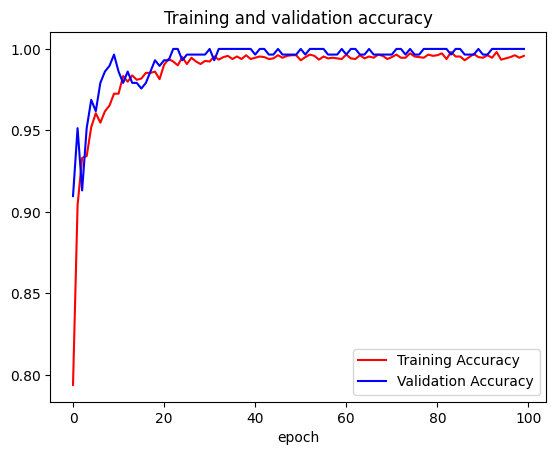

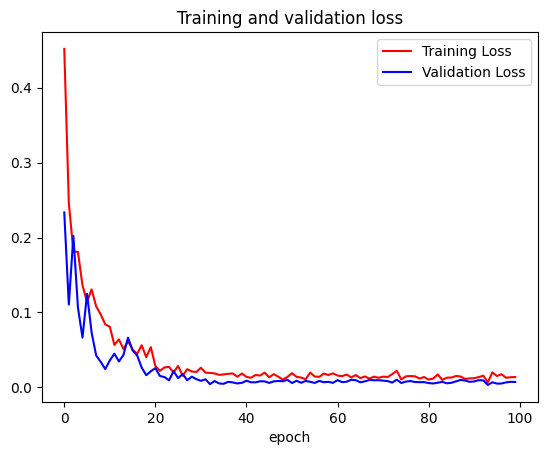

In [13]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
plt.style.use('default')

start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

history = model.fit_generator(
    train_generator, epochs=100, validation_data=val_generator,
    callbacks=[
        ModelCheckpoint('models/%s.h5' % (start_time), monitor='val_acc', save_best_only=True, mode='max', verbose=1),
        ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05)
    ]
)
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', label = "Training Accuracy")
plt.plot(epochs, val_acc, 'b', label = "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.xlabel("epoch")
plt.legend(labels = ["Training Accuracy", "Validation Accuracy"], loc = "best")
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label = "Training Loss")
plt.plot(epochs, val_loss, 'b', label = "Validation Loss")
plt.title('Training and validation loss')
plt.xlabel("epoch")
plt.legend(labels = ["Training Loss", "Validation Loss"], loc = "best")

plt.show()

In [14]:
model.save('eye_detecting.h5')


In [15]:
!cp eye_detecting.h5 /gdrive/MyDrive/tmp/

test acc: 0.9965277777777778


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


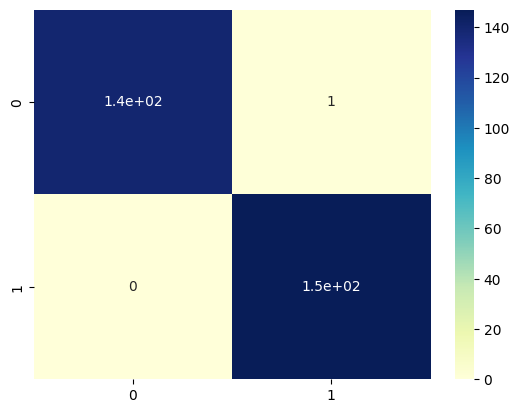

In [16]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

model = load_model('models/%s.h5' % (start_time))

y_pred = model.predict(x_val/255.)
y_pred_logical = (y_pred > 0.5).astype(np.int)

print ('test acc: %s' % accuracy_score(y_val, y_pred_logical))
cm = confusion_matrix(y_val, y_pred_logical)
sns.heatmap(cm, annot=True, cmap="YlGnBu")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


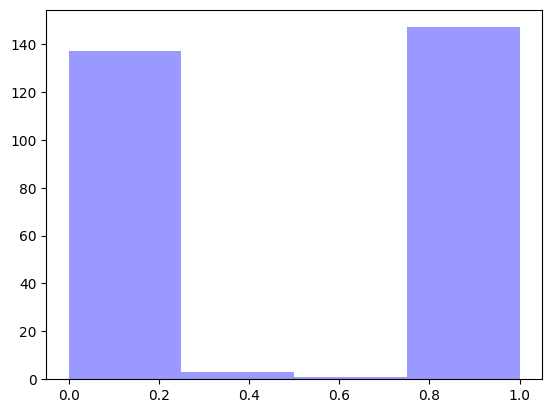

In [17]:
ax = sns.distplot(y_pred, kde=False, color = "Blue")

In [18]:
!pip install dlib opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
